## CIFAR-10 Tutorial

### Training a Classifier

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'

Size: 3 x 32 x 32

Output of torchvision datasets are PILImage images of range [0, 1]

We transform them to Tensors of normalized range [-1, 1]


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

## Load and normalize CIFAR10

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Show some of the training images, for fun.

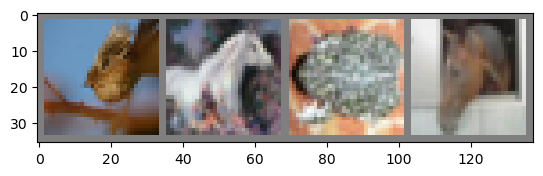

bird  horse frog  horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    """
    show an image
    """
    img = img / 2 + 0.5  # un-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# plt.figure(figsize=[3, 3])  # OK smaller doesn't equal clearer.

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


## Define a Convolutional Neural Network

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


## Define a Loss function and optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


## Train the network

Loop over our data iterator, and feed the inputs to the network and optimize.

In [7]:
# loop over the dataset multiple times
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('\nFinished Training')


[1,  2000] loss: 2.179
[1,  4000] loss: 1.864
[1,  6000] loss: 1.683
[1,  8000] loss: 1.568
[1, 10000] loss: 1.527
[1, 12000] loss: 1.485
[2,  2000] loss: 1.402
[2,  4000] loss: 1.392
[2,  6000] loss: 1.373
[2,  8000] loss: 1.332
[2, 10000] loss: 1.322
[2, 12000] loss: 1.306

Finished Training


## Save it

In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test the network on the test data

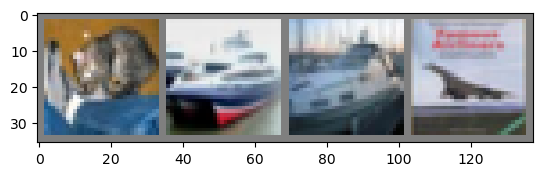


GroundTruth:  cat   ship  ship  plane


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))  # make grid

print('\nGroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


## Load back in our saved model

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Let's see what the neural network thinks these examples above are:

In [13]:
_, predicted = torch.max(outputs, 1)

print('\nPredicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                                for j in range(4)))



Predicted:  cat   frog  car   frog 


### Let's see how the network performs on the whole dataset.

In [14]:
correct = 0
total = 0

# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data

        # calculate outputs by running images through the network
        outputs = net(images)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nAccuracy of the network on the 10000 test images: {100 * correct // total} %')



Accuracy of the network on the 10000 test images: 53 %


That looks way better than **chance, which is 10% accuracy** (randomly picking a class out of 10 classes). Seems like the network learnt something.

### What classes performed well?

In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'\nAccuracy for class: {classname:5s} is {accuracy:.1f} %')



Accuracy for class: plane is 59.9 %

Accuracy for class: car   is 54.8 %

Accuracy for class: bird  is 54.1 %

Accuracy for class: cat   is 37.2 %

Accuracy for class: deer  is 26.7 %

Accuracy for class: dog   is 31.7 %

Accuracy for class: frog  is 66.9 %

Accuracy for class: horse is 67.5 %

Accuracy for class: ship  is 74.5 %

Accuracy for class: truck is 64.0 %
